In [17]:
#algorithm
#https://github.com/SebastianMantey/Naive-Bayes-from-Scratch/blob/main/notebooks/YouTube_videos/03%20-%20second%20step%20of%20algorithm.ipynb

In [18]:
import pandas as pd

In [19]:
df_train=pd.read_csv("processed_train2.csv",index_col='PassengerId')
df_test=pd.read_csv("processed_test2.csv",index_col='PassengerId')

In [20]:
train_data=df_train # training data along with the survived column

test_labels=df_test['Survived']

test_data=df_test.drop(columns='Survived')

In [21]:
def create_table(df, label_column):
    table = {}

    # determine values for the label
    value_counts = df[label_column].value_counts().sort_index()
    table["class_names"] = value_counts.index.to_numpy()
    table["class_counts"] = value_counts.values

    # determine probabilities for the features
    for feature in df.drop(label_column, axis=1).columns:
        table[feature] = {}

        # determine counts
        counts = df.groupby(label_column)[feature].value_counts()
        df_counts = counts.unstack(label_column)

        # add one count to avoid "problem of rare values"
        if df_counts.isna().any(axis=None):
            df_counts.fillna(value=0, inplace=True)
            df_counts += 1

        # calculate probabilities
        df_probabilities = df_counts / df_counts.sum()
        for value in df_probabilities.index:
            probabilities = df_probabilities.loc[value].to_numpy()
            table[feature][value] = probabilities
            
    return table

In [22]:
lookup_table = create_table(train_data, label_column="Survived")
lookup_table

{'class_names': array([0, 1], dtype=int64),
 'class_counts': array([439, 273], dtype=int64),
 'Pclass': {1: array([0.14578588, 0.38827839]),
  2: array([0.17767654, 0.23809524]),
  3: array([0.67653759, 0.37362637])},
 'Sex': {0: array([0.84965831, 0.34065934]),
  1: array([0.15034169, 0.65934066])},
 'Age': {0: array([0.04783599, 0.11721612]),
  1: array([0.10933941, 0.10989011]),
  2: array([0.15489749, 0.1025641 ]),
  3: array([0.14806378, 0.17216117]),
  4: array([0.18678815, 0.17948718]),
  5: array([0.16856492, 0.17216117]),
  6: array([0.18451025, 0.14652015])},
 'SibSp': {0: array([0.71300448, 0.60714286]),
  1: array([0.17713004, 0.31071429]),
  2: array([0.03363229, 0.04285714]),
  3: array([0.02242152, 0.01785714]),
  4: array([0.02690583, 0.01428571]),
  5: array([0.01121076, 0.00357143]),
  8: array([0.01569507, 0.00357143])},
 'Parch': {0: array([0.79820628, 0.66785714]),
  1: array([0.10089686, 0.18571429]),
  2: array([0.06950673, 0.12142857]),
  3: array([0.00672646, 0

In [23]:
def predict_example(row, lookup_table):
    
    class_estimates = lookup_table["class_counts"]
    for feature in row.index:

        try:
            value = row[feature]
            probabilities = lookup_table[feature][value]
            class_estimates = class_estimates * probabilities

        # skip in case "value" only occurs in test set but not in train set
        # (i.e. "value" is not in "lookup_table")
        except KeyError:
            continue

    index_max_class = class_estimates.argmax()
    prediction = lookup_table["class_names"][index_max_class]
    
    return prediction

In [24]:
predictions = df_test.apply(predict_example, axis=1, args=(lookup_table,))
predictions.head()

PassengerId
745    0
160    0
503    0
815    0
589    0
dtype: int64

In [25]:
predictions_correct = predictions == test_labels
accuracy = predictions_correct.mean()
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.810


In [26]:
from sklearn.metrics import confusion_matrix,classification_report

In [27]:
confusion_matrix(test_labels, predictions)


array([[91, 19],
       [15, 54]], dtype=int64)

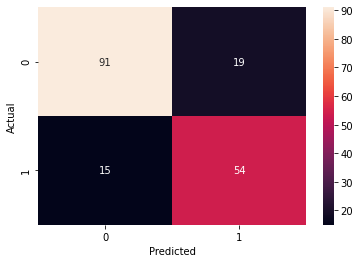

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
data=pd.concat([test_labels,predictions],axis=1)


confusion_matrix = pd.crosstab(test_labels,predictions, rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()


In [29]:
print(classification_report(test_labels,predictions))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       110
           1       0.74      0.78      0.76        69

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



In [30]:
train_labels=df_train['Survived']
df_train=df_train.drop(columns='Survived')

In [31]:
predictions = df_train.apply(predict_example, axis=1, args=(lookup_table,))

In [32]:
predictions_correct = predictions == train_labels
accuracy = predictions_correct.mean()
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.788
